
# Business Questions: Part2

    1. Focus on missed appointments

-------

# Logic: 

> Objective is to view two perspectives; Patients and Staff 
> - Important questions: 
>    1. How do missed appointments influences Staff workload? [Total appointments]

-------

# Assumptions:

- 1 appointment equals use of staff & infrastructure/resources
- Duplicates can exist 1 patient can have follow-up appointments
- Unknown value in both categorical columns, appointment_status and hcp_type, are unreliable observations

--------

# Risk
- 1 appointment equals 1 patients will assume there is more patients in current data set 
    - negative gives impression current patients number
    - positive gives the correct capacity since staff & infrastructure is utilize everytime an appointment is made



-------

# Outline:
    0. Setup
    1. Getting to know your data
    2. Cleaning data

--------

# Approach: 

- AR data set: Perform comparitive analysis by identify difference between Missed appointments and Attended appointments
    - Requires understanding of AR since it contains appointment status:
        1. Overview of big picture: Total appointments 
        2. Micro: Total appointments per appointment status type (i.e. Attended, Missed, Unknown)
        3. Contextualize Micro within Macro: Percentage of each status type
        4. Verify observation counts per status type: Can be misleading
        5. Use Average to compare status appointment type if observations are uneven
        6. Summarize finding using visualization


        

In [1]:
# Import jupyter
import jupyter_black

jupyter_black.load()

## 0. Setup

In [2]:
# Import modules/libraries needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Absolute path per data source
ad_path = (
    "/Volumes/Macintosh HD - Data/tmp/LSE_DA201_Assignment_files/actual_duration.csv"
)
ar_path = "/Volumes/Macintosh HD - Data/tmp/LSE_DA201_Assignment_files/appointments_regional.csv"
nc_path = "/Volumes/Macintosh HD - Data/tmp/LSE_DA201_Assignment_files/national_categories.xlsx"

In [4]:
# Importation of data source csv files
ad = pd.read_csv(ad_path)
ar = pd.read_csv(ar_path)

# Importation of data source xlsx file
nc = pd.read_excel(nc_path)

## 1. Getting to know your data
- Scope & Summary:
    - Using ar since it contains status appointment and interest for client
    - Columns of interest; count_of_appointment only numeric, appointment_status, appointment_mode (characterists of possible distinction), time_between_book_and_appointment

In [5]:
# Back up
ar_profile = ar

# Verify head()
display(ar_profile.head())

# Verify no footnote of raw data or metadata
display(ar_profile.tail())

,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments
0,E54000034,2020-01,Attended,GP,Face-to-Face,1 Day,8107
1,E54000034,2020-01,Attended,GP,Face-to-Face,15 to 21 Days,6791
2,E54000034,2020-01,Attended,GP,Face-to-Face,2 to 7 Days,20686
3,E54000034,2020-01,Attended,GP,Face-to-Face,22 to 28 Days,4268
4,E54000034,2020-01,Attended,GP,Face-to-Face,8 to 14 Days,11971


,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments
596816,E54000050,2022-06,Unknown,Unknown,Unknown,2 to 7 Days,21
596817,E54000050,2022-06,Unknown,Unknown,Unknown,22 to 28 Days,8
596818,E54000050,2022-06,Unknown,Unknown,Unknown,8 to 14 Days,28
596819,E54000050,2022-06,Unknown,Unknown,Unknown,More than 28 Days,17
596820,E54000050,2022-06,Unknown,Unknown,Unknown,Same Day,10


In [6]:
# Overview for numeric attributes
display(ar_profile.describe())

# Overview for categorical attributes
display(ar_profile.astype("category").describe())

# Overview of dtypes and missing values
display(ar_profile.info())

,count_of_appointments
count,596821.000000
mean,1244.601857
std,5856.887042
min,1.000000
25%,7.000000
50%,47.000000
75%,308.000000
max,211265.000000


,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments
count,596821,596821,596821,596821,596821,596821,596821
unique,42,30,3,3,5,8,22807
top,E54000057,2020-03,Attended,Other Practice staff,Face-to-Face,Same Day,1
freq,54527,21350,232137,241557,180410,95502,55013


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 7 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   icb_ons_code                       596821 non-null  object
 1   appointment_month                  596821 non-null  object
 2   appointment_status                 596821 non-null  object
 3   hcp_type                           596821 non-null  object
 4   appointment_mode                   596821 non-null  object
 5   time_between_book_and_appointment  596821 non-null  object
 6   count_of_appointments              596821 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 31.9+ MB


None

Comment:
- Majority of dtype are object which is default when python is unsure: need for data transformation via conversion of dtype
- count_of_appointments seems only numeric column available in AR data set: perfect candidate for outliers detection and possible consistency improvement
- Based on info() there seems to be no missing values, metadata indicates that values entitled 'Unknown' are missing values these are found in:
    - appointment_status (candidate for missing value)
    - hcp_type (candidate for missing value)

Insights:
- Mode per column: meaning most probable observation combination
1. E54000057
2. 2020-03
3. Attended
4. Other Practice staff
5. Face-to-Face
6. Same Day
7. 1


## 2. Cleaning data:
Purpose: to improve data quality

> Preparing deals with convenient formatting for analysis
>   - Transform data is another term for it 
>   - Duplicates

> Cleaning deals with finding and fixing errors
>   - Outliers
>   - Missing values


### 2.1 Transform data: conversion dtype
- demonstrate non-destructive cleaning 
    - avoids loss of original data
    - allows for experimentation
    - methods and functions available in python have limitations or constriction based dtype
> Transformation of data for analytical purposes to facilitate analysis based on approach or objective:
> 1. convertion of data types 
> 2. subsetting
> 3. pivot table
> 4. join, merge, concat


In [7]:
# Convert dtype - datetime

# Datatime
ar_profile["appointment_month_dt"] = pd.to_datetime(
    ar_profile["appointment_month"], format="%Y-%m"
)

# Verify conversion done
display(ar_profile["appointment_month_dt"].info())
display(ar_profile["appointment_month_dt"].head())

<class 'pandas.core.series.Series'>
RangeIndex: 596821 entries, 0 to 596820
Series name: appointment_month_dt
Non-Null Count   Dtype         
--------------   -----         
596821 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 4.6 MB


None

0   2020-01-01
1   2020-01-01
2   2020-01-01
3   2020-01-01
4   2020-01-01
Name: appointment_month_dt, dtype: datetime64[ns]

Comment:
- Useful for time series analysis; seasonal, trend, moving average

Insights:
- appointment_month: datetime
- four categorical or string: appointment_status, hcp_type, appointment_mode, time_between_book_and_appointment
- one numeric:count_of_appointments [already in proper format]

In [8]:
# Convert categorical attributes
# Non destructive cleaning - appointment_status
ar_profile["appointment_status_ct"] = ar_profile["appointment_status"].astype(
    "category"
)

# Non destructive cleaning - hcp_type
ar_profile["hcp_type_ct"] = ar_profile["hcp_type"].astype("category")

# Non destructive cleaning - appointment_mode
ar_profile["appointment_mode_ct"] = ar_profile["appointment_mode"].astype("category")

# Non destructive cleaning - appointment_mode
ar_profile["time_between_book_and_appointment_ct"] = ar_profile[
    "time_between_book_and_appointment"
].astype("category")

# View
ar_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   icb_ons_code                          596821 non-null  object        
 1   appointment_month                     596821 non-null  object        
 2   appointment_status                    596821 non-null  object        
 3   hcp_type                              596821 non-null  object        
 4   appointment_mode                      596821 non-null  object        
 5   time_between_book_and_appointment     596821 non-null  object        
 6   count_of_appointments                 596821 non-null  int64         
 7   appointment_month_dt                  596821 non-null  datetime64[ns]
 8   appointment_status_ct                 596821 non-null  category      
 9   hcp_type_ct                           596821 non-null  cate

Comment:
- Non-destructive cleaning technique allows for flexibility based on need by adding columns instead of replacing values, the original data remains intact (risk averse strategy avoids loss of data)

Risk:
- Non-destructive cleaning is time consuming and increase memory, not possible for big data sets



### 2.2 Outliers: improve consistency 
> Methods/approaches:
>   1. IQR technique
>   2. Z-score technique
>   3. Tukey's fence technique
>> ML methods:
>>  1. Isolation forest
>>  2. Local outler

------

**Steps**:
1. Boxplot - use for numeric columns 
2. Histgram - skewness and distribution 
    - Normal distribution use mean if imputation technique is used
    - Skewed distribution use median if imputation technique is used
3. Select appropriate approach based on analytical questions
    - Possible to do also an comparative analysis

#### 2.2.1 Overview of outliers

<Axes: ylabel='count_of_appointments'>

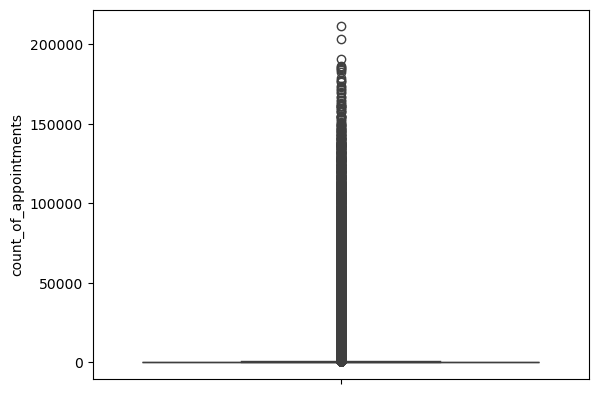

In [9]:
# Subset ar data set and create variable
ar_outliers = ar_profile.copy()

# Plot boxplot
sns.boxplot(data=ar_outliers["count_of_appointments"])

'Skewness of ar containing outliers: 11.52'

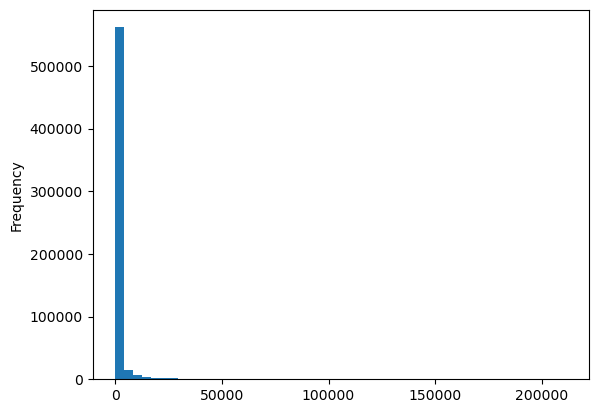

In [10]:
# Find out distribution if it skewed or not; indicates which imputation statistic will be used mean (not skewed) or median (skewed)
# Plot histogram - distribution
ar_outliers["count_of_appointments"].plot(kind="hist", bins=50)

# Skewness
ar_skewness = ar_outliers["count_of_appointments"].skew()
display(f"Skewness of ar containing outliers: {ar_skewness:.2f}")

Insight:
- Distribution skewed to the right
- Skewness value = 11.52
- If using impute method to deal with outlier better choice would be median since it not normally distributed

#### 2.2.2 Z-score technique

In [11]:
# Z-score method of identify outliers
ar_outliers["z_score"] = (
    np.abs(
        ar_outliers["count_of_appointments"]
        - ar_outliers["count_of_appointments"].mean()
    )
    / ar_outliers["count_of_appointments"].std()
)

# Subset of outliers only
outlier_z_score = ar_outliers[ar_outliers["z_score"] > 3]

# Summary and verification
display(
    f"The number of observation that are z_score outliers: {outlier_z_score.shape[0]:,}",
    f"The number of observations without outliers: {ar_profile.shape[0] - outlier_z_score.shape[0]:,}",
    f"The number of observations with outliers: {ar_profile.shape[0]:,}",
    f"Percentage of outliers using z-score: {(outlier_z_score.shape[0]/ar_profile.shape[0]):.2%}",
)

'The number of observation that are z_score outliers: 8,670'

'The number of observations without outliers: 588,151'

'The number of observations with outliers: 596,821'

'Percentage of outliers using z-score: 1.45%'

<Axes: ylabel='count_of_appointments'>

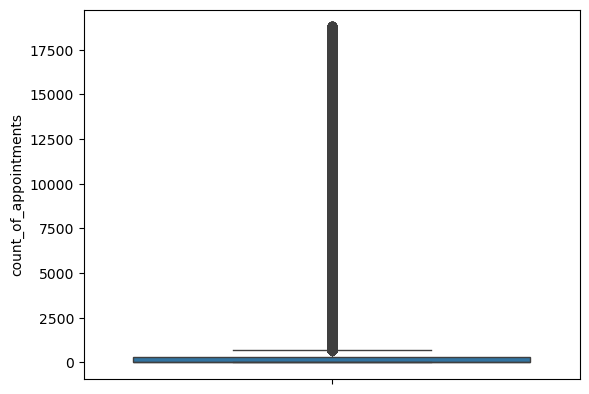

In [12]:
# Subset of without outliers
ar_without_outlier_z = ar_outliers[ar_outliers["z_score"] <= 3]

# Check
ar_without_outlier_z.shape[0]

# Plot boxplot: z-score
sns.boxplot(data=ar_without_outlier_z["count_of_appointments"])

<Axes: ylabel='Frequency'>

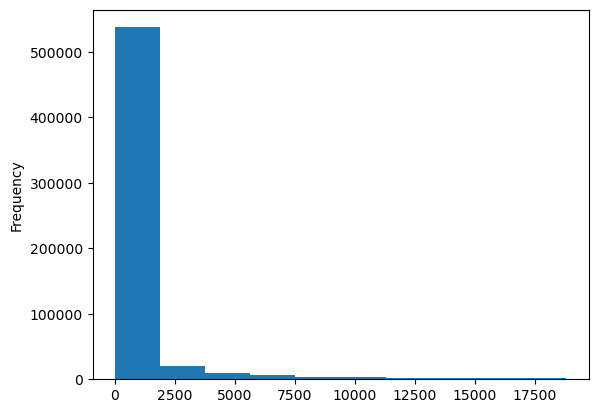

In [13]:
# Plot histgram: z-score
ar_without_outlier_z["count_of_appointments"].plot(kind="hist")

#### 2.2.3 IQR technique

In [14]:
# IQR technique
# Calculate Q1, Q3, and IQR
Q1 = ar_outliers["count_of_appointments"].quantile(0.25)
Q3 = ar_outliers["count_of_appointments"].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a boolean mask for outliers
outlier_mask = (ar_outliers["count_of_appointments"] < lower_bound) | (
    ar_outliers["count_of_appointments"] > upper_bound
)

# Apply the mask to filter outliers
outliers_iqr = ar_outliers[outlier_mask]

# Subset without outlier using iqr method
ar_without_outlier_iqr = ar_outliers[~outlier_mask]

# Summary & Overview
display(ar_without_outlier_iqr.shape[0])

print(f"Original ar_outliers: {ar_outliers.shape[0]:,}")
print(f"\nNumber of observation that are outliers using iqr: {outliers_iqr.shape[0]:,}")
print(
    f"\nNumber of observation that without outliers using iqr: {ar_without_outlier_iqr.shape[0]:,}"
)
print(
    f"\nOutlier percentage using IQR: {(outliers_iqr.shape[0]/ar_outliers.shape[0]):.2%}"
)

499473

Original ar_outliers: 596,821

Number of observation that are outliers using iqr: 97,348

Number of observation that without outliers using iqr: 499,473

Outlier percentage using IQR: 16.31%


<Axes: ylabel='count_of_appointments'>

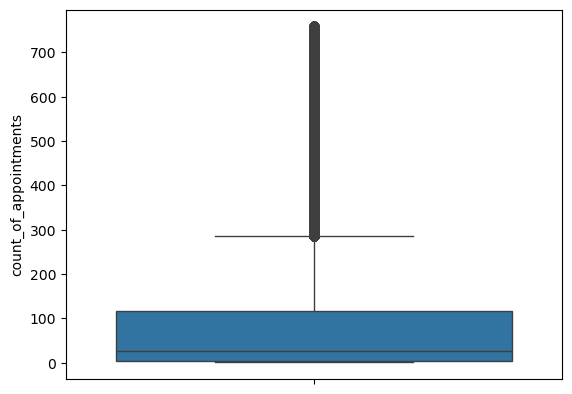

In [15]:
# Plot boxplot
sns.boxplot(data=ar_without_outlier_iqr["count_of_appointments"])

<Axes: ylabel='Frequency'>

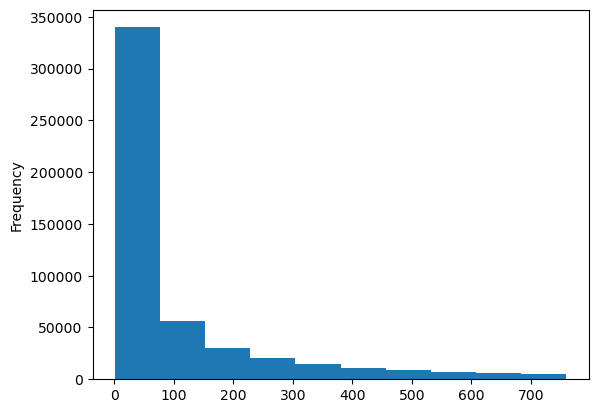

In [16]:
# Histogram
ar_without_outlier_iqr["count_of_appointments"].plot(kind="hist")

#### 2.2.4 Compare outlier techniques: IQR vs Z-score

In [17]:
# Compare outlier techniques iqr vs z-score
display(ar_without_outlier_z["count_of_appointments"].describe())
display(ar_without_outlier_iqr["count_of_appointments"].describe())

count    588151.000000
mean        681.655973
std        2080.072633
min           1.000000
25%           6.000000
50%          44.000000
75%         279.000000
max       18813.000000
Name: count_of_appointments, dtype: float64

count    499473.000000
mean         97.705724
std         154.644489
min           1.000000
25%           5.000000
50%          26.000000
75%         117.000000
max         759.000000
Name: count_of_appointments, dtype: float64

Insights:
- IQR technique provides more standardized output by eliminating 16.31% observation
- Z-score is further from normal distribution because it eliminates 1.41% observation 

Comment:
- to select which is best suited we should look at the missed appointments


In [18]:
# Comparing outliers techniques - how it effects objective of analytical questions
# View iqr subset without outliers
display(ar_without_outlier_iqr["appointment_status"].value_counts())

# View z-score subset without outliers
display(ar_without_outlier_z["appointment_status"].value_counts())

# View original data set ar with outliers
display(ar_profile["appointment_status"].value_counts())

appointment_status
Unknown     190602
Attended    156074
DNA         152797
Name: count, dtype: int64

appointment_status
Attended    223467
Unknown     201324
DNA         163360
Name: count, dtype: int64

appointment_status
Attended    232137
Unknown     201324
DNA         163360
Name: count, dtype: int64

Insight:
- iqr format provides a more equal representation of type, which would be great if it was not for unknown which is a null
- z-score eliminates only the most extreme value but it only effected attended values, the remainder type remain unchanged

Comment:
- 2 issues with outlier solution: 
    1. skewness both remained right skewed distribution
    2. amount lost of observations
- Main concerns is selection is based on objective and objective is missed appointments 
    - comparative analysis to find the most suitable in this case


### 2.3 Duplicates 

In [19]:
# Duplicates check - entire data set AR
display(ar_profile.duplicated().value_counts())
display(ar_profile.duplicated().value_counts(normalize=True))

# Subset duplicates and verify it matches
display(ar_profile[ar_profile.duplicated() == True].shape[0])

# View subset
display(ar_profile[ar_profile.duplicated() == True].describe())

# Compared to orginal
ar_profile.describe()

False    575217
True      21604
Name: count, dtype: int64

False    0.963802
True     0.036198
Name: proportion, dtype: float64

21604

,count_of_appointments,appointment_month_dt
count,21604.000000,21604
mean,12.718293,2021-03-16 11:19:40.448065280
min,1.000000,2020-01-01 00:00:00
25%,1.000000,2020-08-01 00:00:00
50%,2.000000,2021-03-01 00:00:00
75%,6.000000,2021-11-01 00:00:00
max,9737.000000,2022-06-01 00:00:00
std,103.259831,NaN


,count_of_appointments,appointment_month_dt
count,596821.000000,596821
mean,1244.601857,2021-03-19 11:31:17.489565696
min,1.000000,2020-01-01 00:00:00
25%,7.000000,2020-08-01 00:00:00
50%,47.000000,2021-04-01 00:00:00
75%,308.000000,2021-11-01 00:00:00
max,211265.000000,2022-06-01 00:00:00
std,5856.887042,NaN


Insights:
- 3.6% of are duplicate values
- duplicate values have a small spread, and their weighted average is 12.7 appointments, which makes sense since the majority of values are withing 1 to 6 appointments count range


In [20]:
# Is there a location that produce more duplicates than other?

# Subset duplicates of ar
ar_duplicates = ar_profile[ar_profile.duplicated() == True]

# Groupby icb_ons_code - location with the highest total appointments duplicates
# Sum
display(
    ar_duplicates.groupby("icb_ons_code")["count_of_appointments"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Groupby icb_ons_code - location with the highest number appointment duplicates
# Count
display(
    ar_duplicates.groupby("icb_ons_code")["count_of_appointments"]
    .count()
    .sort_values(ascending=False)
    .head(10)
)

icb_ons_code
E54000057    76630
E54000008    35677
E54000048    35126
E54000050    29414
E54000051    19398
E54000026    18649
E54000010    16423
E54000054    15367
E54000061     8298
E54000023     6450
Name: count_of_appointments, dtype: int64

icb_ons_code
E54000057    4552
E54000008    3369
E54000048    2883
E54000050    2849
E54000010    1670
E54000051    1638
E54000054     982
E54000026     857
E54000061     771
E54000044     506
Name: count_of_appointments, dtype: int64

In [21]:
# Create variable and explore
ar_duplicates = ar_profile[ar_profile.duplicated() == True]

# View duplicates
ar_duplicates.value_counts().sort_values(ascending=False)

icb_ons_code  appointment_month  appointment_status  hcp_type  appointment_mode  time_between_book_and_appointment  count_of_appointments  appointment_month_dt  appointment_status_ct  hcp_type_ct  appointment_mode_ct  time_between_book_and_appointment_ct
E54000008     2021-07            DNA                 GP        Home Visit        2 to 7 Days                        1                      2021-07-01            DNA                    GP           Home Visit           2 to 7 Days                             6
E54000057     2021-12            DNA                 GP        Home Visit        8  to 14 Days                      1                      2021-12-01            DNA                    GP           Home Visit           8  to 14 Days                           6
              2020-10            Unknown             GP        Home Visit        15  to 21 Days                     1                      2020-10-01            Unknown                GP           Home Visit           15  to 

In [22]:
# Subset ar_duplicates contains 21604
# Hypothesis is that most of it comes from unknown value either in appointment_status or hcp_type

# Verify appointment status
display(ar_duplicates["appointment_status"].value_counts())
display(ar_duplicates["appointment_status"].value_counts(normalize=True))

# Verify hcp_type
display(ar_duplicates["hcp_type"].value_counts())
display(ar_duplicates["hcp_type"].value_counts(normalize=True))

# Total unknown value contained within duplicates data set
display(f"Total number of values with Unknown as value: {7950 + 6270}")

appointment_status
Unknown     7950
DNA         7812
Attended    5842
Name: count, dtype: int64

appointment_status
Unknown     0.367987
DNA         0.361600
Attended    0.270413
Name: proportion, dtype: float64

hcp_type
GP                      8208
Other Practice staff    7126
Unknown                 6270
Name: count, dtype: int64

hcp_type
GP                      0.379930
Other Practice staff    0.329846
Unknown                 0.290224
Name: proportion, dtype: float64

'Total number of values with Unknown as value: 14220'

Insights:
- Unknown is the largest observation demography in duplicates data set, followed by DNA aka missed appointments


In [23]:
# Observation appointment_status
display(ar_profile["appointment_status"].value_counts())
display(ar_profile["appointment_status"].value_counts(normalize=True))

# Observation hcp_type
display(ar_profile["hcp_type"].value_counts())
display(ar_profile["hcp_type"].value_counts(normalize=True))

appointment_status
Attended    232137
Unknown     201324
DNA         163360
Name: count, dtype: int64

appointment_status
Attended    0.388956
Unknown     0.337327
DNA         0.273717
Name: proportion, dtype: float64

hcp_type
Other Practice staff    241557
GP                      226036
Unknown                 129228
Name: count, dtype: int64

hcp_type
Other Practice staff    0.404739
GP                      0.378733
Unknown                 0.216527
Name: proportion, dtype: float64

In [24]:
# Removing duplicates that contains unknown in both hcp_type and appointment_status
# Too many part attributes missing and unreliable quality of data

# Subset orginal
ar_poor_obs = ar_profile[
    (ar_profile["hcp_type_ct"].str.contains("Unknown"))
    & (ar_profile["appointment_status_ct"].str.contains("Unknown"))
]

# Subset without unreliable observation
ar_cl = ar_profile[
    ~(ar_profile["hcp_type_ct"].str.contains("Unknown"))
    & ~(ar_profile["appointment_status_ct"].str.contains("Unknown"))
]

# Check
display(
    f"Number of unreliable observations: {ar_poor_obs.shape[0]:,}",
    f"Number of observations from original data set: {ar_profile.shape[0]:,}",
    f"Percentage of unreliable observations: {ar_poor_obs.shape[0]/ar_profile.shape[0]:.2%}",
    f"Number of observation remaining: {ar_cl.shape[0]:,}",
    f"Number of duplicates from original data set: {ar_profile.duplicated().sum():,}",
    f"Number of duplicates reliable data set: {ar_cl.duplicated().sum():,}",
    f"Percentage of duplicate reduction: {1-ar_cl.duplicated().sum() / ar_profile.duplicated().sum():.2%}",
    f"Total missed appointments of original: {ar_profile.loc[ar_profile['appointment_status_ct']== "DNA", 'count_of_appointments'].sum():,}",
    f"Total missed appointments of reliable data set: {ar_cl.loc[ar_cl['appointment_status_ct']== "DNA", 'count_of_appointments'].sum():,}",
    f"Percentage reduction of missed appointments: {1- ar_cl.loc[ar_cl['appointment_status_ct']== "DNA", 'count_of_appointments'].sum() / ar_profile.loc[ar_profile['appointment_status_ct']== "DNA", 'count_of_appointments'].sum():.2%}",
    f"Total attended appointments of original: {ar_profile.loc[ar_profile['appointment_status_ct']== "Attended", 'count_of_appointments'].sum():,}",
    f"Total attended appointments of reliable data set: {ar_cl.loc[ar_cl['appointment_status_ct']== "Attended", 'count_of_appointments'].sum():,}",
    f"Percentage reduction of attended appointments: {1- ar_cl.loc[ar_cl['appointment_status_ct']== "Attended", 'count_of_appointments'].sum() / ar_profile.loc[ar_profile['appointment_status_ct']== "Attended", 'count_of_appointments'].sum():.2%}",
)

'Number of unreliable observations: 46,232'

'Number of observations from original data set: 596,821'

'Percentage of unreliable observations: 7.75%'

'Number of observation remaining: 312,501'

'Number of duplicates from original data set: 21,604'

'Number of duplicates reliable data set: 9,763'

'Percentage of duplicate reduction: 54.81%'

'Total missed appointments of original: 30,911,233'

'Total missed appointments of reliable data set: 30,258,270'

'Percentage reduction of missed appointments: 2.11%'

'Total attended appointments of original: 677,755,876'

'Total attended appointments of reliable data set: 656,976,582'

'Percentage reduction of attended appointments: 3.07%'

Comment:
- "Garbage in garbage out" high quality data is needed for accurate insights and analysis
- Duplicates remain since an appointment can represent the same patient, and when looking at capacity both staff and resources are utilized when appointment is made (occupancy)


Insights:
- 7.75% of observations are unreliable observations
- 54.81% reduction of duplicates observations (all missing values from entire data)
- Unknown value exist only as duplicate and if value is present in categorical columns; appointment_status & hcp_type
- Total appointments was reduced by 5.18%, impact of unknown value  

In [25]:
# Check if Unknown value remain within appointment_status
display(ar_cl["appointment_status_ct"].value_counts())

# Check if Unknown value remain within hcp_type
display(ar_cl["hcp_type_ct"].value_counts())

appointment_status_ct
Attended    178720
DNA         133781
Unknown          0
Name: count, dtype: int64

hcp_type_ct
Other Practice staff    161845
GP                      150656
Unknown                      0
Name: count, dtype: int64

In [26]:
# What was the impact of unknown in terms of count_of_appointments
display(
    f'Total appointments with unknown categorical value: {ar_profile.loc[ar_profile["appointment_status_ct"].str.contains("Unknown"),"count_of_appointments"].sum():,}'
)

# What portions of total does it have
display(
    f'Total appointments of entire data set AR: {ar_profile["count_of_appointments"].sum():,}'
)

# Represents 4.6% total appointments
display(
    f'Appointment Percentage containing Unknown as a values: {ar_profile.loc[ar_profile["appointment_status_ct"].str.contains("Unknown"),"count_of_appointments"].sum()/ ar_profile["count_of_appointments"].sum():.2%}'
)

'Total appointments with unknown categorical value: 34,137,416'

'Total appointments of entire data set AR: 742,804,525'

'Appointment Percentage containing Unknown as a values: 4.60%'

### 2.4 Missing value:
Metadata:
- Indicated that 'Unknown' value represent missing value
 
Insight:
- Only existed if it contained 'Unknown' as a value
- 'Unknown' value is MCAR because was present in two columns simultaneously  


In [27]:
# Number of null values
ar_profile.isnull().sum()

icb_ons_code                            0
appointment_month                       0
appointment_status                      0
hcp_type                                0
appointment_mode                        0
time_between_book_and_appointment       0
count_of_appointments                   0
appointment_month_dt                    0
appointment_status_ct                   0
hcp_type_ct                             0
appointment_mode_ct                     0
time_between_book_and_appointment_ct    0
dtype: int64

In [28]:
# How many null values exist within the original data set?
# Back up
ar2 = ar_profile.copy()

# Check unique values for appointment status
display(ar2["appointment_status"].unique())

# Replace Unknown with null value
ar2["appointment_status_cl"] = ar2["appointment_status"].replace("Unknown", np.nan)

# Count
display(ar2.isnull().sum())

# Shape and check
ar2.shape

array(['Attended', 'DNA', 'Unknown'], dtype=object)

icb_ons_code                                 0
appointment_month                            0
appointment_status                           0
hcp_type                                     0
appointment_mode                             0
time_between_book_and_appointment            0
count_of_appointments                        0
appointment_month_dt                         0
appointment_status_ct                        0
hcp_type_ct                                  0
appointment_mode_ct                          0
time_between_book_and_appointment_ct         0
appointment_status_cl                   201324
dtype: int64

(596821, 13)

In [29]:
# Check unique values for appointment status
display(ar2["hcp_type"].unique())

# Replace Unknown with null value
ar2["hcp_type_cl"] = ar2["hcp_type"].replace("Unknown", np.nan)

# Count
display(ar2.isnull().sum())

array(['GP', 'Other Practice staff', 'Unknown'], dtype=object)

icb_ons_code                                 0
appointment_month                            0
appointment_status                           0
hcp_type                                     0
appointment_mode                             0
time_between_book_and_appointment            0
count_of_appointments                        0
appointment_month_dt                         0
appointment_status_ct                        0
hcp_type_ct                                  0
appointment_mode_ct                          0
time_between_book_and_appointment_ct         0
appointment_status_cl                   201324
hcp_type_cl                             129228
dtype: int64

In [30]:
# How many null value in clean duplicate data set
# Number of null values in ar_cl
display(ar_cl["hcp_type_ct"].value_counts())
display(ar_cl["appointment_status_ct"].value_counts())

hcp_type_ct
Other Practice staff    161845
GP                      150656
Unknown                      0
Name: count, dtype: int64

appointment_status_ct
Attended    178720
DNA         133781
Unknown          0
Name: count, dtype: int64

In [31]:
ar_profile.columns

Index(['icb_ons_code', 'appointment_month', 'appointment_status', 'hcp_type',
       'appointment_mode', 'time_between_book_and_appointment',
       'count_of_appointments', 'appointment_month_dt',
       'appointment_status_ct', 'hcp_type_ct', 'appointment_mode_ct',
       'time_between_book_and_appointment_ct'],
      dtype='object')

In [32]:
ar2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 14 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   icb_ons_code                          596821 non-null  object        
 1   appointment_month                     596821 non-null  object        
 2   appointment_status                    596821 non-null  object        
 3   hcp_type                              596821 non-null  object        
 4   appointment_mode                      596821 non-null  object        
 5   time_between_book_and_appointment     596821 non-null  object        
 6   count_of_appointments                 596821 non-null  int64         
 7   appointment_month_dt                  596821 non-null  datetime64[ns]
 8   appointment_status_ct                 596821 non-null  category      
 9   hcp_type_ct                           596821 non-null  cate

In [33]:
ar_cl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 312501 entries, 0 to 596745
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   icb_ons_code                          312501 non-null  object        
 1   appointment_month                     312501 non-null  object        
 2   appointment_status                    312501 non-null  object        
 3   hcp_type                              312501 non-null  object        
 4   appointment_mode                      312501 non-null  object        
 5   time_between_book_and_appointment     312501 non-null  object        
 6   count_of_appointments                 312501 non-null  int64         
 7   appointment_month_dt                  312501 non-null  datetime64[ns]
 8   appointment_status_ct                 312501 non-null  category      
 9   hcp_type_ct                           312501 non-null  category 

In [34]:
# Apply z-score outliers technique
ar_cl

,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments,appointment_month_dt,appointment_status_ct,hcp_type_ct,appointment_mode_ct,time_between_book_and_appointment_ct
0,E54000034,2020-01,Attended,GP,Face-to-Face,1 Day,8107,2020-01-01,Attended,GP,Face-to-Face,1 Day
1,E54000034,2020-01,Attended,GP,Face-to-Face,15 to 21 Days,6791,2020-01-01,Attended,GP,Face-to-Face,15 to 21 Days
2,E54000034,2020-01,Attended,GP,Face-to-Face,2 to 7 Days,20686,2020-01-01,Attended,GP,Face-to-Face,2 to 7 Days
3,E54000034,2020-01,Attended,GP,Face-to-Face,22 to 28 Days,4268,2020-01-01,Attended,GP,Face-to-Face,22 to 28 Days
4,E54000034,2020-01,Attended,GP,Face-to-Face,8 to 14 Days,11971,2020-01-01,Attended,GP,Face-to-Face,8 to 14 Days
...,...,...,...,...,...,...,...,...,...,...,...,...
596741,E54000050,2022-06,DNA,Other Practice staff,Telephone,2 to 7 Days,80,2022-06-01,DNA,Other Practice staff,Telephone,2 to 7 Days
596742,E54000050,2022-06,DNA,Other Practice staff,Telephone,22 to 28 Days,26,2022-06-01,DNA,Other Practice staff,Telephone,22 to 28 Days
596743,E54000050,2022-06,DNA,Other Practice staff,Telephone,8 to 14 Days,46,2022-06-01,DNA,Other Practice staff,Telephone,8 to 14 Days
596744,E54000050,2022-06,DNA,Other Practice staff,Telephone,More than 28 Days,30,2022-06-01,DNA,Other Practice staff,Telephone,More than 28 Days


----------------

## 3. Analysis
- Apply z-score outliers technique onto ar_cl
- Mode profile comparison analysis: original dataset, subset z-score outlier

### 3.1 Outliers z-score subset

In [35]:
# Z-score method of identify outliers
ar_cl["z_score"] = (
    np.abs(ar_cl["count_of_appointments"] - ar_cl["count_of_appointments"].mean())
    / ar_cl["count_of_appointments"].std()
)


display(ar_cl.columns)

# Subset of outliers only
ar_cl_z = ar_cl[ar_cl["z_score"] <= 3]

ar_cl["z_score"].describe()

/var/folders/8k/55fh57h90358qjj7hbtlynp00000gn/T/ipykernel_1179/3286931683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ar_cl["z_score"] = (


Index(['icb_ons_code', 'appointment_month', 'appointment_status', 'hcp_type',
       'appointment_mode', 'time_between_book_and_appointment',
       'count_of_appointments', 'appointment_month_dt',
       'appointment_status_ct', 'hcp_type_ct', 'appointment_mode_ct',
       'time_between_book_and_appointment_ct', 'z_score'],
      dtype='object')

count    312501.000000
mean          0.411008
std           0.911631
min           0.000018
25%           0.240574
50%           0.271759
75%           0.276160
max          26.289575
Name: z_score, dtype: float64

In [36]:
ar_cl_z["z_score"].describe()

count    306781.000000
mean          0.310279
std           0.316713
min           0.000018
25%           0.239065
50%           0.271382
75%           0.276035
max           2.999822
Name: z_score, dtype: float64

------

### 3.0 Comparative analysis appointment_status and most common observation

In [37]:
# Descriptive overview - mode per column
display(ar_cl.astype("category").describe())

# Most common observation for Missed appointment
display(
    ar_cl.loc[ar_cl["appointment_status_ct"] == "DNA"].astype("category").describe()
)

# Most common observation for Attended
display(
    ar_cl.loc[ar_cl["appointment_status_ct"] == "Attended"]
    .astype("category")
    .describe()
)

,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments,appointment_month_dt,appointment_status_ct,hcp_type_ct,appointment_mode_ct,time_between_book_and_appointment_ct,z_score
count,312501,312501,312501,312501,312501,312501,312501,312501,312501,312501,312501,312501,312501.000000
unique,42,30,2,2,5,8,22690,30,2,2,5,8,22690.000000
top,E54000057,2020-03,Attended,Other Practice staff,Face-to-Face,Same Day,1,2020-03-01 00:00:00,Attended,Other Practice staff,Face-to-Face,Same Day,0.276412
freq,27948,10957,178720,161845,95914,47603,23311,10957,178720,161845,95914,47603,23311.000000


,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments,appointment_month_dt,appointment_status_ct,hcp_type_ct,appointment_mode_ct,time_between_book_and_appointment_ct,z_score
count,133781,133781,133781,133781,133781,133781,133781,133781,133781,133781,133781,133781,133781.000000
unique,42,30,1,2,5,8,3615,30,1,2,5,8,3615.000000
top,E54000057,2020-03,DNA,Other Practice staff,Face-to-Face,Same Day,1,2020-03-01 00:00:00,DNA,Other Practice staff,Face-to-Face,Same Day,0.276412
freq,12143,4891,133781,70993,46213,21531,14045,4891,133781,70993,46213,21531,14045.000000


,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments,appointment_month_dt,appointment_status_ct,hcp_type_ct,appointment_mode_ct,time_between_book_and_appointment_ct,z_score
count,178720,178720,178720,178720,178720,178720,178720,178720,178720,178720,178720,178720,178720.000000
unique,42,30,1,2,5,8,22664,30,1,2,5,8,22664.000000
top,E54000057,2021-11,Attended,Other Practice staff,Face-to-Face,Same Day,1,2021-11-01 00:00:00,Attended,Other Practice staff,Face-to-Face,Same Day,0.276412
freq,15805,6160,178720,90852,49701,26072,9266,6160,178720,90852,49701,26072,9266.000000


Insights:
- 2020-03 busiest for entire data set & missed appointments: indicates possible peak
- 2021-11 busiest for attended appointments: 
- The difference between original data set, missed, and attended: indicate possible seasonality  

In [38]:
# Descriptive overview - mode per column
display(ar_cl_z.astype("category").describe())

# Most common observation for Missed appointment
display(
    ar_cl_z.loc[ar_cl_z["appointment_status_ct"] == "DNA"].astype("category").describe()
)

# Most common observation for Attended
display(
    ar_cl_z.loc[ar_cl_z["appointment_status_ct"] == "Attended"]
    .astype("category")
    .describe()
)

,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments,appointment_month_dt,appointment_status_ct,hcp_type_ct,appointment_mode_ct,time_between_book_and_appointment_ct,z_score
count,306781,306781,306781,306781,306781,306781,306781,306781,306781,306781,306781,306781,306781.000000
unique,42,30,2,2,5,8,17361,30,2,2,5,8,17361.000000
top,E54000057,2020-03,Attended,Other Practice staff,Face-to-Face,2 to 7 Days,1,2020-03-01 00:00:00,Attended,Other Practice staff,Face-to-Face,2 to 7 Days,0.276412
freq,27867,10811,173000,159365,92302,45587,23311,10811,173000,159365,92302,45587,23311.000000


,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments,appointment_month_dt,appointment_status_ct,hcp_type_ct,appointment_mode_ct,time_between_book_and_appointment_ct,z_score
count,133781,133781,133781,133781,133781,133781,133781,133781,133781,133781,133781,133781,133781.000000
unique,42,30,1,2,5,8,3615,30,1,2,5,8,3615.000000
top,E54000057,2020-03,DNA,Other Practice staff,Face-to-Face,Same Day,1,2020-03-01 00:00:00,DNA,Other Practice staff,Face-to-Face,Same Day,0.276412
freq,12143,4891,133781,70993,46213,21531,14045,4891,133781,70993,46213,21531,14045.000000


,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments,appointment_month_dt,appointment_status_ct,hcp_type_ct,appointment_mode_ct,time_between_book_and_appointment_ct,z_score
count,173000,173000,173000,173000,173000,173000,173000,173000,173000,173000,173000,173000,173000.000000
unique,42,30,1,2,5,8,17335,30,1,2,5,8,17335.000000
top,E54000057,2020-03,Attended,Other Practice staff,Telephone,1 Day,1,2020-03-01 00:00:00,Attended,Other Practice staff,Telephone,1 Day,0.276412
freq,15724,5920,173000,88372,46267,25220,9266,5920,173000,88372,46267,25220,9266.000000


Insights:
- Comparison of prior and after outliers:
    - Attended status value from appointment_mode changed to Telephone, 1 Day waiting time
    - Missed status value same day 
    - Ar with outliers from 2 to 7 days

- Notable difference: variation in appointment_month is now standard 2020-03-01

### 3.1 Analysis of Missed Appointments
- Verify hypothesis from Mode profile comparison: 
    - Conclusion: 2020-03 is a seasonal peak and not trend peak or an overall peak

- Barcharts: 
    1. Comparing Missed and Attended Total Appointments
    2. Barchart: Total Missed Appointments by Month
    3. Barchart: Total Attended Appointments by Month

- Time Series Analysis: Trend, Season, Residual, and Original

In [40]:
# Trend of totals
# Subset missed
missed_subset = ar_cl_z.loc[ar_cl_z["appointment_status_ct"].str.contains("DNA")]

# Subset attended
attended_subset = ar_cl_z.loc[ar_cl_z["appointment_status_ct"].str.contains("Attended")]

# View
display(missed_subset.shape)
display(attended_subset.shape)

(133781, 13)

(173000, 13)

In [139]:
# highest months
highest_month_apt = ar_cl_z.pivot_table(
    "count_of_appointments",
    index="appointment_month_dt",
    columns="appointment_status_ct",
    aggfunc="sum",
)

# Remove Unknown column
highest_month_apt = highest_month_apt.drop(columns="Unknown")

# Verifiy
highest_month_apt.head()

/var/folders/8k/55fh57h90358qjj7hbtlynp00000gn/T/ipykernel_1179/2382996296.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  highest_month_apt = ar_cl_z.pivot_table(


appointment_status_ct,Attended,DNA
appointment_month_dt,,
2020-01-01,13256960,1277743
2020-02-01,12545481,1196735
2020-03-01,13093833,1147260
2020-04-01,8049934,469136
2020-05-01,8800295,440102


<Axes: xlabel='appointment_month_dt'>

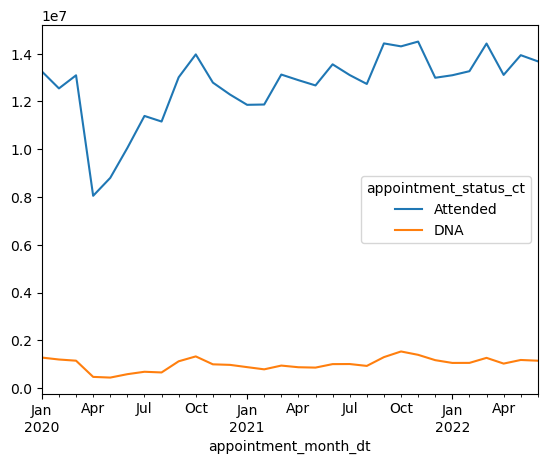

In [124]:
# Plot lineplot
highest_month_apt.plot(kind="line")

/var/folders/8k/55fh57h90358qjj7hbtlynp00000gn/T/ipykernel_1179/2549198985.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=highest_month_apt.reset_index(), ci=None)


Text(0.5, 0, 'Status of Appointment')

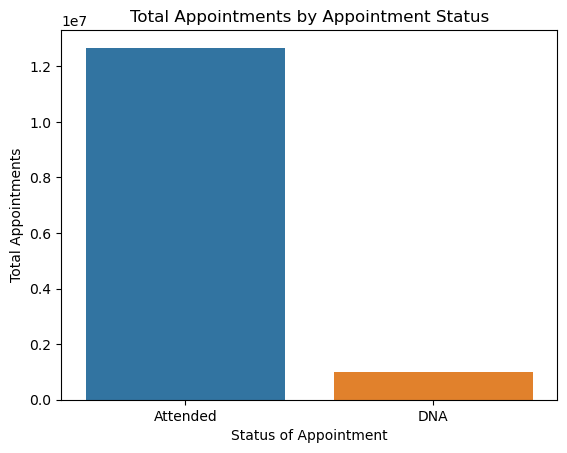

In [132]:
# Barplot - combined
sns.barplot(data=highest_month_apt.reset_index(), ci=None)

# Labels
plt.title("Total Appointments by Appointment Status")
plt.ylabel("Total Appointments")
plt.xlabel("Status of Appointment")

In [117]:
# Highest months - Missed
highest_month_missed_apt = missed_subset.pivot_table(
    "count_of_appointments",
    index="appointment_month_dt",
    columns="appointment_status_ct",
    aggfunc="sum",
)

# Remove unknown and Attended column
highest_month_missed_apt = highest_month_missed_apt.drop(
    columns=["Unknown", "Attended"]
)

# Verify
highest_month_missed_apt.head()

/var/folders/8k/55fh57h90358qjj7hbtlynp00000gn/T/ipykernel_1179/3037832777.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  highest_month_missed_apt = missed_subset.pivot_table(


appointment_status_ct,DNA
appointment_month_dt,
2020-01-01,1277743
2020-02-01,1196735
2020-03-01,1147260
2020-04-01,469136
2020-05-01,440102


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '2021-10-01 00:00:00'),
  Text(1, 0, '2021-11-01 00:00:00'),
  Text(2, 0, '2020-10-01 00:00:00'),
  Text(3, 0, '2021-09-01 00:00:00'),
  Text(4, 0, '2020-01-01 00:00:00')])

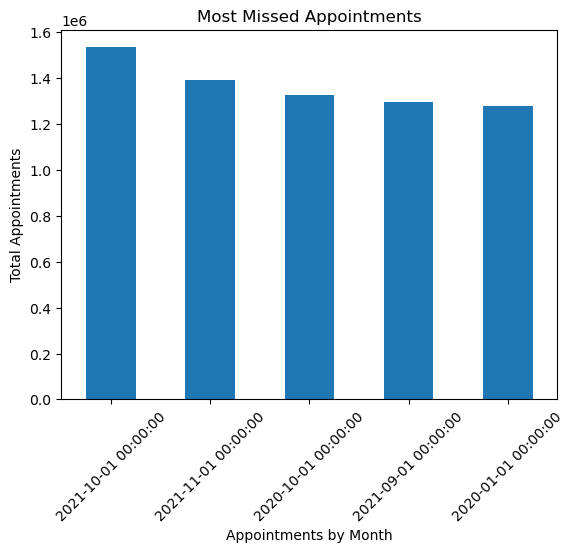

In [138]:
# Plot bargraph - missed
highest_month_missed_apt.sort_values(by="DNA", ascending=False).head().plot(
    kind="bar", legend=None
)

# Labels
plt.title("Most Missed Appointments")
plt.ylabel("Total Appointments")
plt.xlabel("Appointments by Month")
plt.xticks(rotation=45)

Insights:
- Busiest month October, 2021
- 3 out of top 5 busiest months are in 2021
- Busiest months occur during the Autumn and Winter periods (make sense people get ill more during months with colder temperatures and end up not visiting)

Text(0.5, 0, 'Appointments by Month')

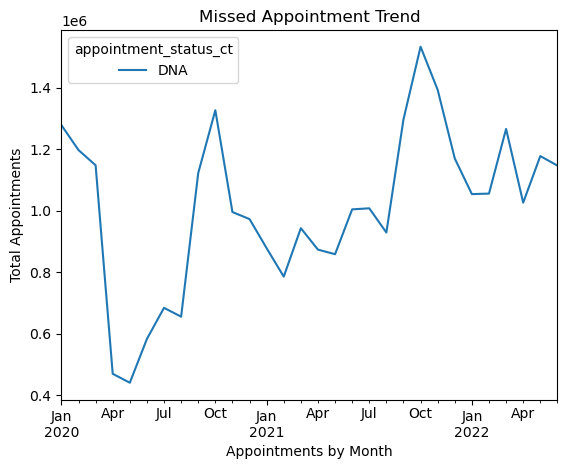

In [99]:
# Plot line - missed
highest_month_missed_apt.plot(kind="line", legend=None)

# Labels
plt.title("Missed Appointment Trend")
plt.ylabel("Total Appointments")
plt.xlabel("Appointments by Month")

# 

Insights:
- Peaks appear in Octorber for Missed Appointments, and in increasing rate

Comment:
- Interesting point in granular analysis at later point for the exact reason why
- Another interesting point would be to make a predictive model to see if it would reoccur in 2022, however Covid is 1 time event that would definely disrupted the pattern

In [101]:
# Highest months - Attended
highest_month_attended_apt = attended_subset.pivot_table(
    "count_of_appointments",
    index="appointment_month_dt",
    columns="appointment_status_ct",
    aggfunc="sum",
)

# Remove Unknown and DNA
highest_month_attended_apt = highest_month_attended_apt.drop(columns=["Unknown", "DNA"])

# Verify
highest_month_attended_apt.head()

/var/folders/8k/55fh57h90358qjj7hbtlynp00000gn/T/ipykernel_1179/2882175871.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  highest_month_attended_apt = attended_subset.pivot_table(


appointment_status_ct,Attended
appointment_month_dt,
2020-01-01,13256960
2020-02-01,12545481
2020-03-01,13093833
2020-04-01,8049934
2020-05-01,8800295


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '2021-11-01 00:00:00'),
  Text(1, 0, '2021-09-01 00:00:00'),
  Text(2, 0, '2022-03-01 00:00:00'),
  Text(3, 0, '2021-10-01 00:00:00'),
  Text(4, 0, '2020-10-01 00:00:00')])

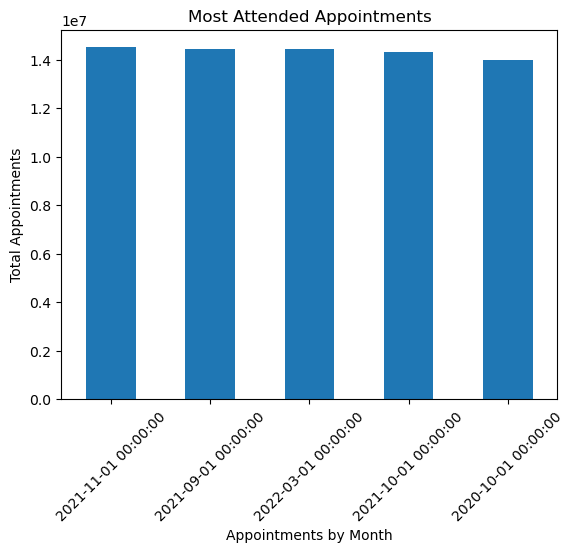

In [142]:
# Plot bargraph - attended
highest_month_attended_apt.sort_values(by="Attended", ascending=False).head().plot(
    kind="bar", legend=None
)

# Labels
plt.title("Most Attended Appointments")
plt.ylabel("Total Appointments")
plt.xlabel("Appointments by Month")
plt.xticks(rotation=45)

Insights:
- 2021 year with the busiest months (validates that there is an increase in appointments from previous year)
- Difference from missed appointments seems 2022-03 possibly the first evidence of Covid cases 

Text(0.5, 0, 'Appointments by Month')

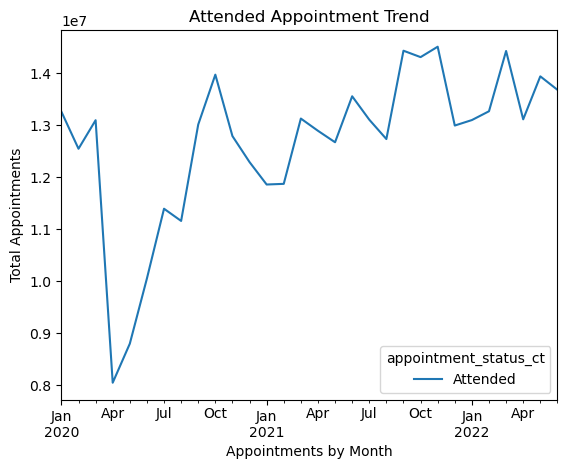

In [143]:
# Plot trend line for Attended status
highest_month_attended_apt.plot(kind="line", legend=None)

# Labels
plt.title("Attended Appointment Trend")
plt.ylabel("Total Appointments")
plt.xlabel("Appointments by Month")

### 3.2 Time Series Analysis: Trend, Seasonality, and Residual

In [52]:
# Import
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [62]:
# Subset and transform for time series analysis
timeseries = ar_cl_z.copy()

# Tranform data - easier format for analysis pivot table
ts = timeseries.pivot_table(
    index="appointment_month_dt", values="count_of_appointments", aggfunc="sum"
)


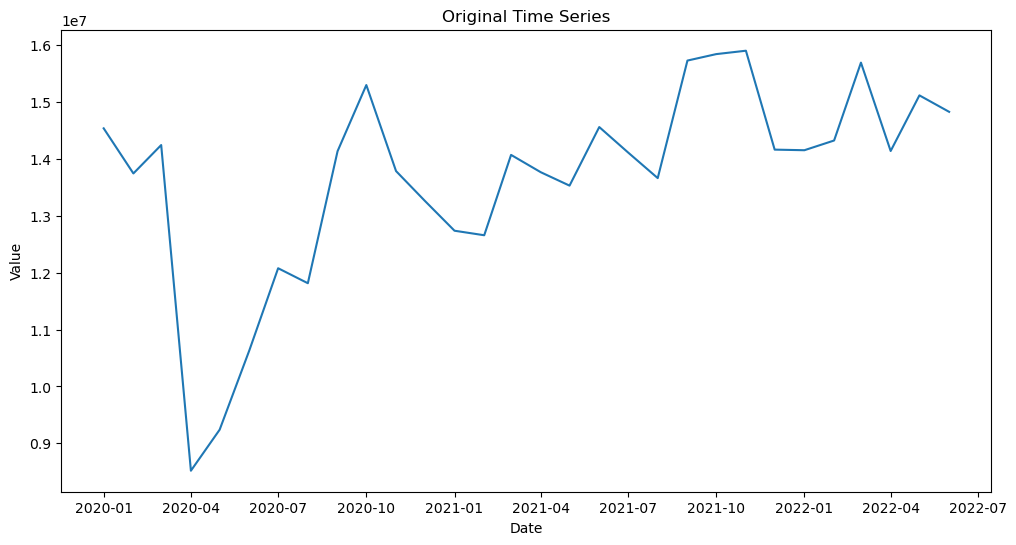

In [63]:
# Visualize raw data
plt.figure(figsize=(12, 6))
plt.plot(
    ts.index,
    ts["count_of_appointments"],
)
plt.title("Original Time Series")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

In [64]:
# Perform the Augmented Dickey-Fuller test to check for stationarity
result = adfuller(ts["count_of_appointments"], autolag="AIC")
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -2.3952713345038354
p-value: 0.14307548998620845
Critical Values: {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}


Insight:
- Augmented Dickey-Fuller test states series is unlikely to be stationary, since p-values is greater than 0.05

<Figure size 1200x800 with 0 Axes>

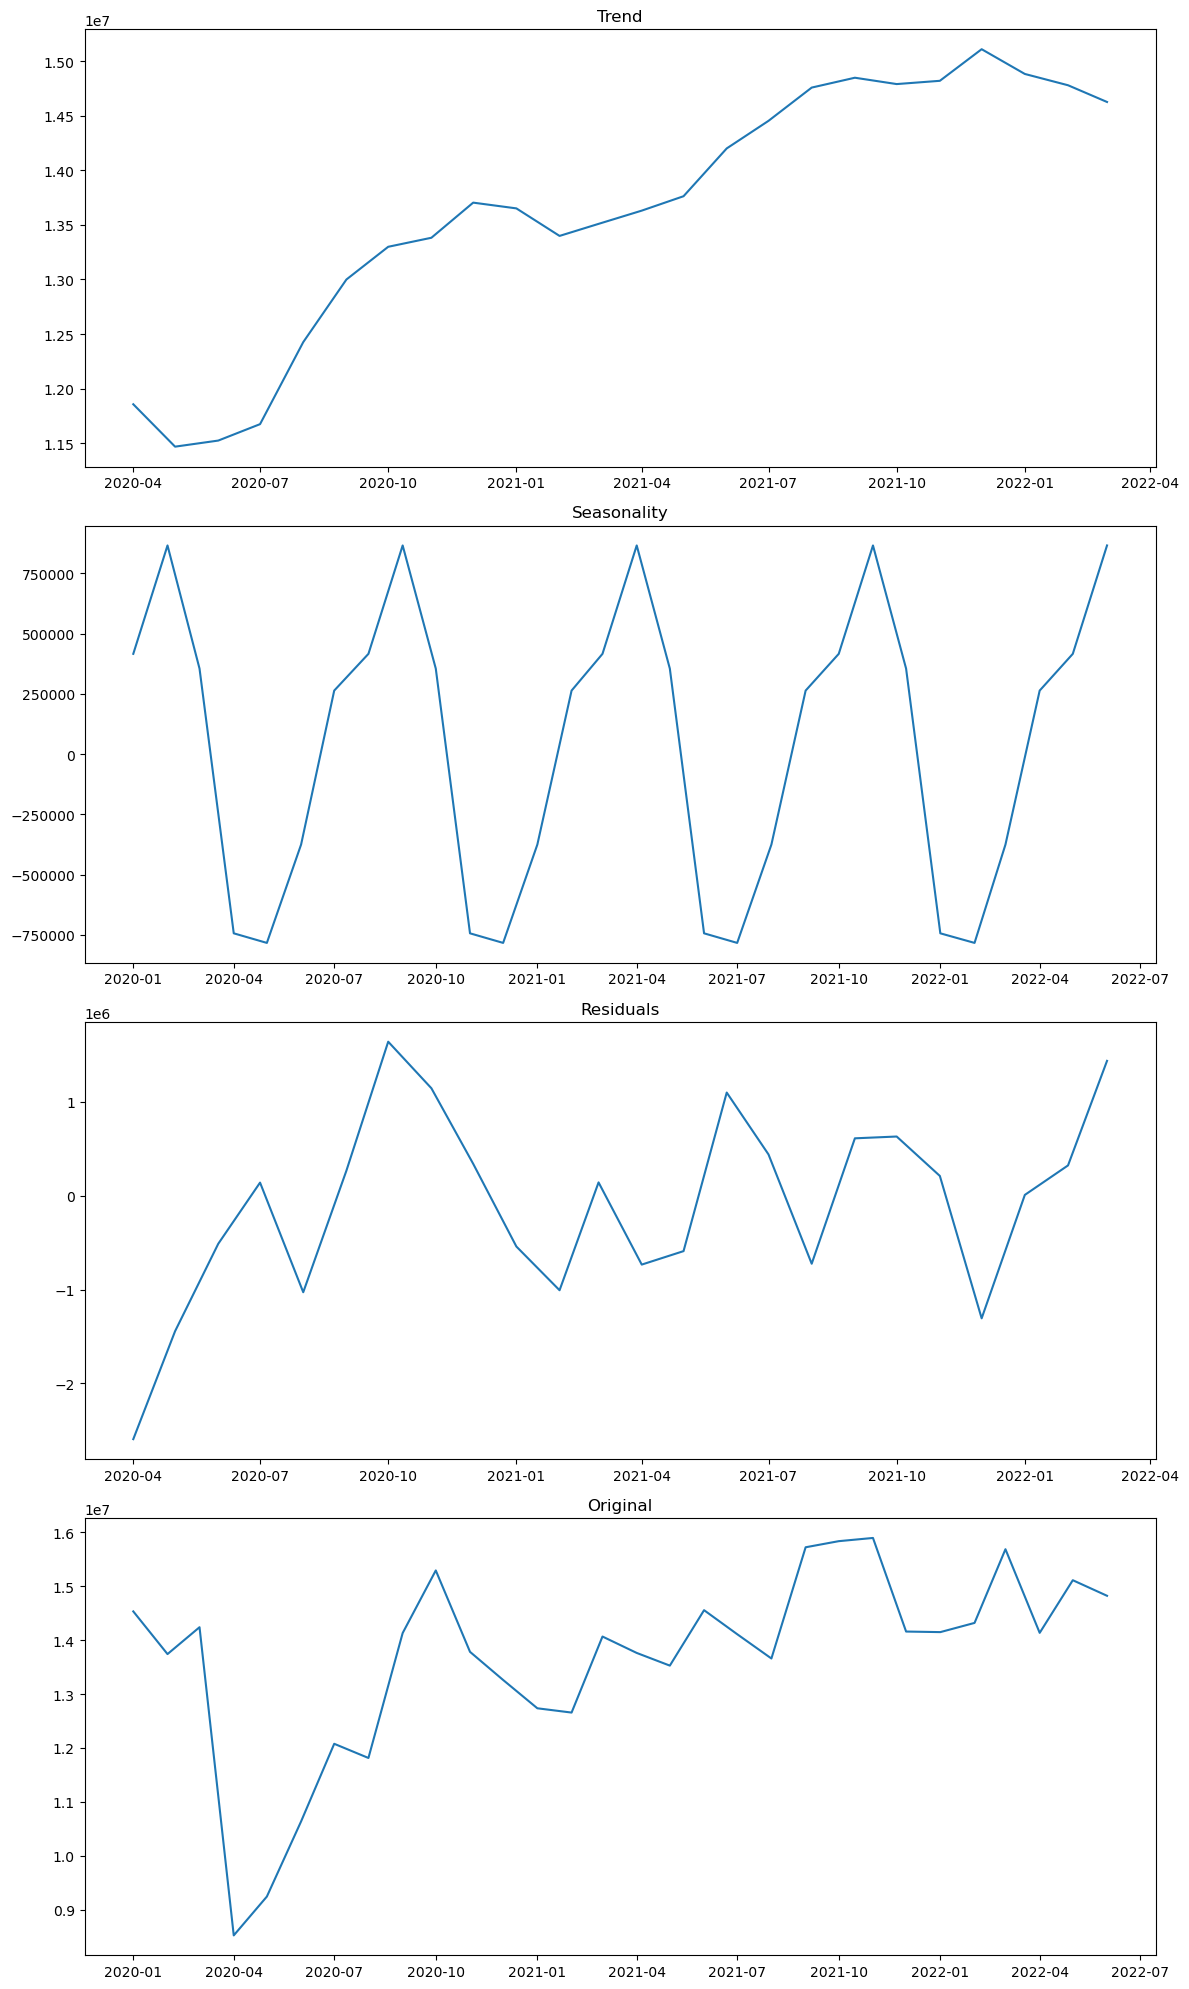

In [65]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(
    ts["count_of_appointments"], model="additive", period=7
)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot Trend, Seasonality, Residuals, and Raw data
plt.figure(figsize=(12, 8))
fig, axes = plt.subplots(4, 1, figsize=(12, 20))
axes[0].plot(trend)
axes[0].set_title("Trend")
axes[1].plot(seasonal)
axes[1].set_title("Seasonality")
axes[2].plot(residual)
axes[2].set_title("Residuals")
axes[3].plot(ts.index, ts["count_of_appointments"])
axes[3].set_title("Original")
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

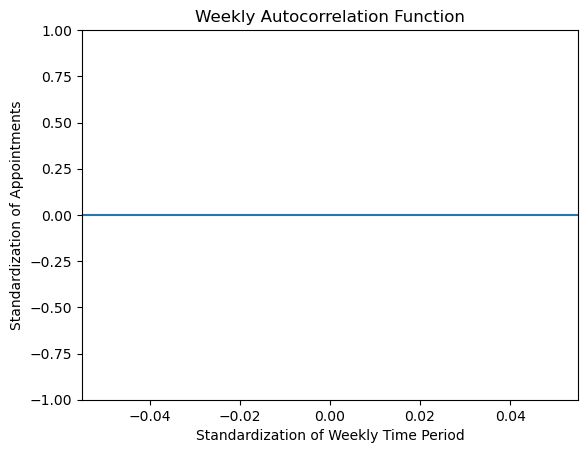

In [109]:
# Analyze weekly pattern
plt.figure(figsize=(12, 6))

# Random sampling by week - performing and plotting acf
plot_acf(ts["count_of_appointments"].resample("W").mean(), lags=52)

# Labels
plt.title("Weekly Autocorrelation Function")
plt.xlabel("Standardization of Weekly Time Period")
plt.ylabel("Standardization of Appointments")

# View
plt.show()

Insight:
- Autocorrelation function (ACF) indicates no weekly pattern was found

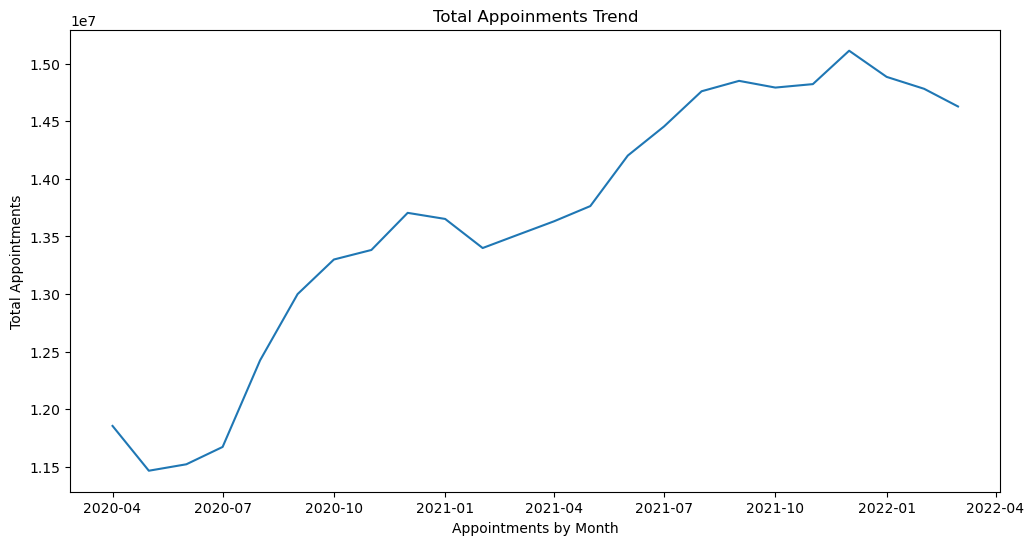

In [105]:
# Plot trend analysis
plt.figure(figsize=(12, 6))
plt.plot(trend)

# Labels
plt.title("Total Appoinments Trend")
plt.xlabel("Appointments by Month")
plt.ylabel("Total Appointments")

# View
plt.show()

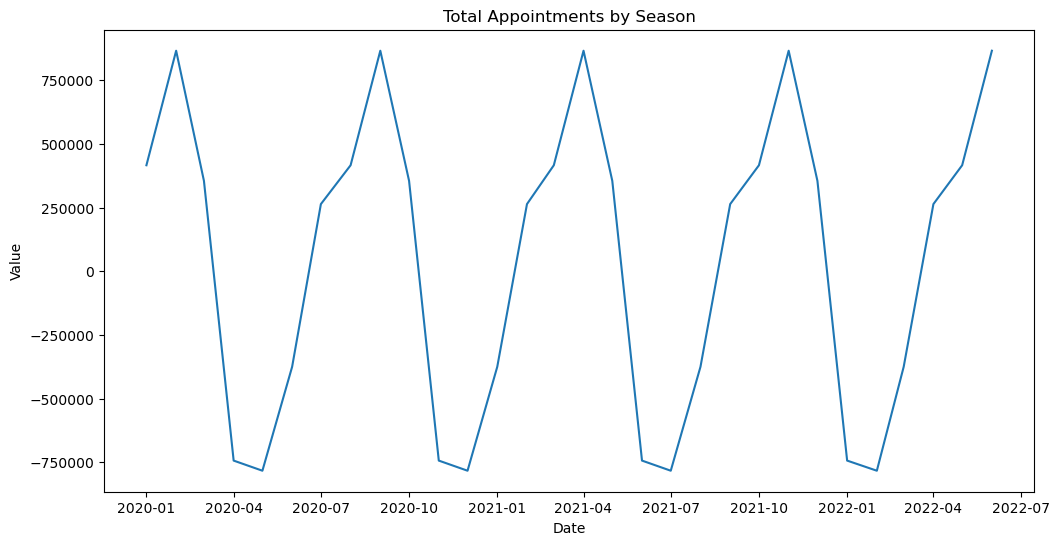

In [106]:
# Plot seasonal
plt.figure(figsize=(12, 6))
plt.plot(seasonal)

# Labels
plt.title("Total Appointments by Season")
plt.xlabel("Date")
plt.ylabel("Value")

# View
plt.show()

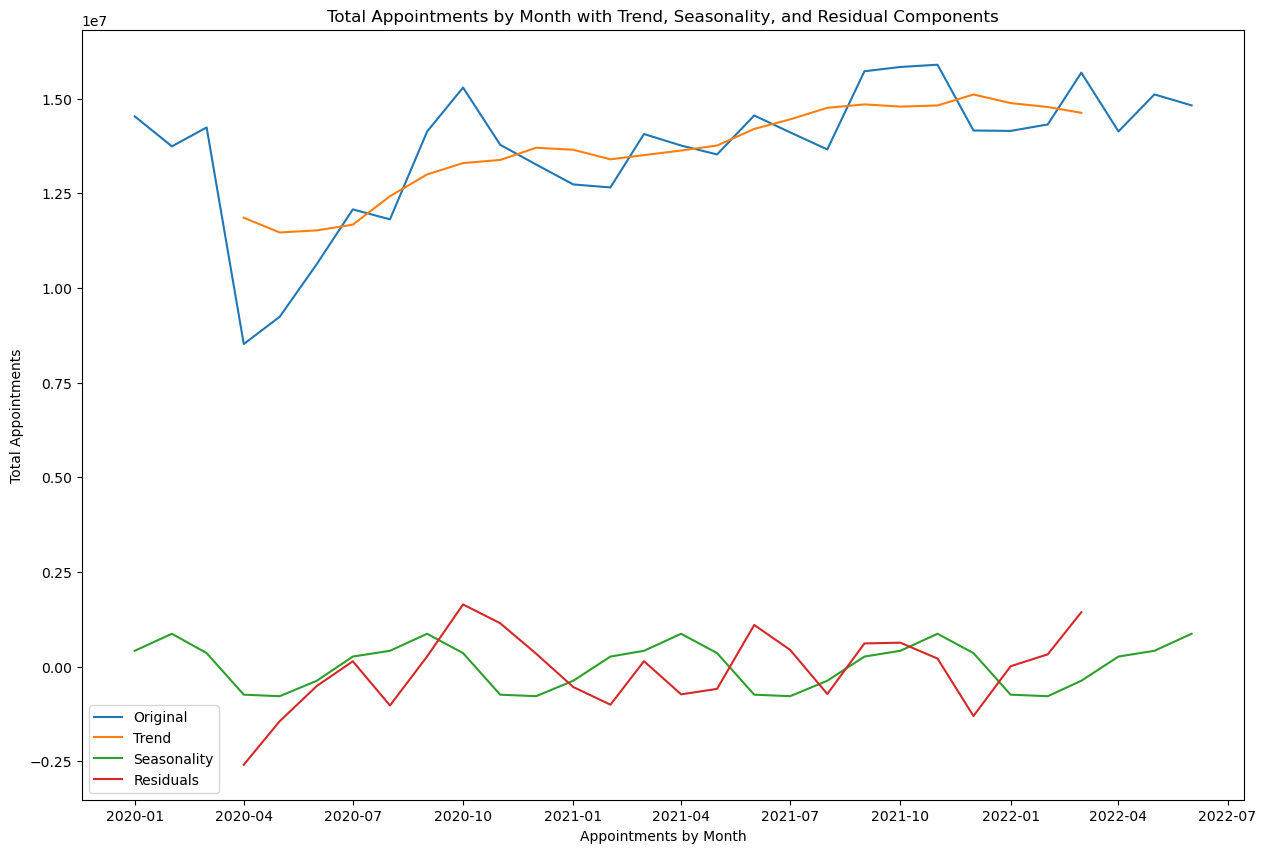

In [108]:
# Tranformation by creation of DF with combined Time Analyses
combined = pd.DataFrame(
    {
        "Original": ts["count_of_appointments"],
        "Trend": trend,
        "Seasonality": seasonal,
        "Residuals": residual,
    }
)

# Plotting combine Time analyses
plt.figure(figsize=(15, 10))
for col in combined.columns:
    plt.plot(combined.index, combined[col], label=col)

# Labels
plt.legend()
plt.title(
    "Total Appointments by Month with Trend, Seasonality, and Residual Components"
)
plt.xlabel("Appointments by Month")
plt.ylabel("Total Appointments")

# View
plt.show()